In [1]:
!pip install -q transformers datasets torchvision torchaudio pytorch-lightning
!pip install -q git+https://github.com/huggingface/transformers
!pip install -q sentencepiece scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 57.4 MB/s eta 0:00:00
  Installing build dependencies ... done


In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if device.type == "cuda":
    print("GPU name:", torch.cuda.get_device_name(0))
    print("Memory available (MB):", torch.cuda.get_device_properties(0).total_memory // (1024 * 1024))


Using device: cuda
GPU name: Tesla T4
Memory available (MB): 15095


In [4]:
!pip install -U fsspec


In [1]:
!pip install -U datasets


In [2]:
from datasets import load_dataset

# Load the IAM-line dataset using streaming
dataset = load_dataset("Teklia/IAM-line", split='train', streaming=True)

# Convert the streaming dataset to a list for processing
dataset_list = list(dataset)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.14k [00:00<?, ?B/s]

Sample 1:
Text: put down a resolution on the subject


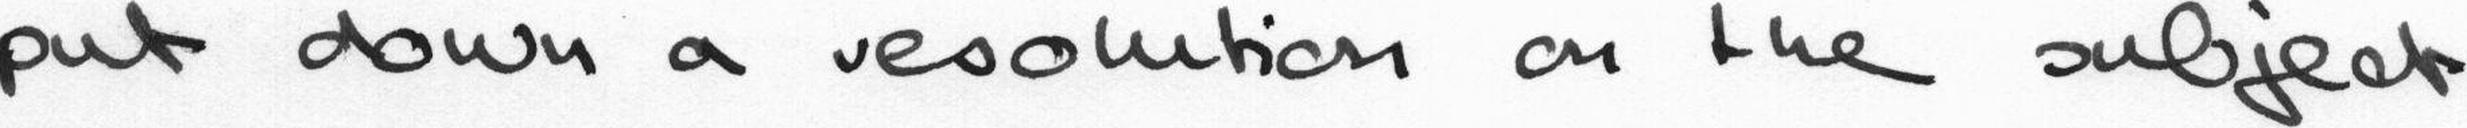

Sample 2:
Text: and he is to be backed by Mr. Will


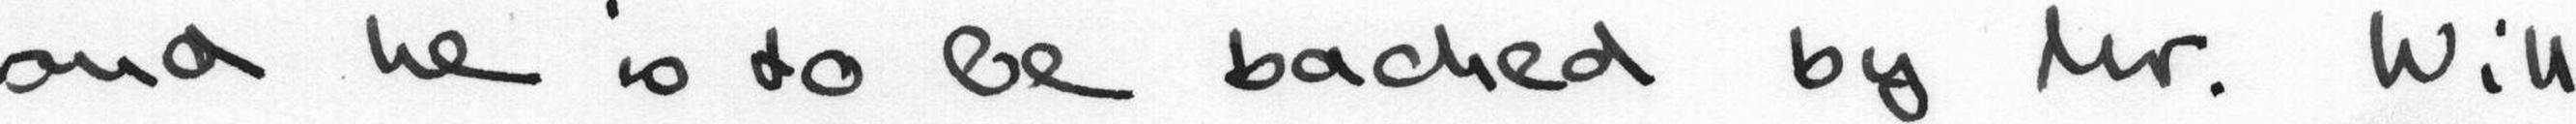

Sample 3:
Text: nominating any more Labour life Peers


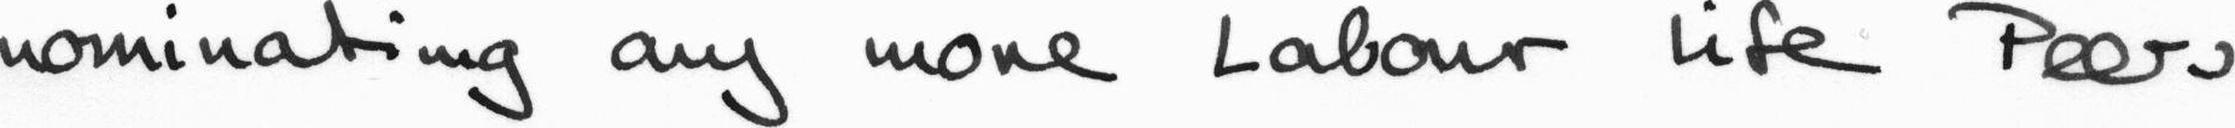

Sample 4:
Text: M Ps tomorrow. Mr. Michael Foot has


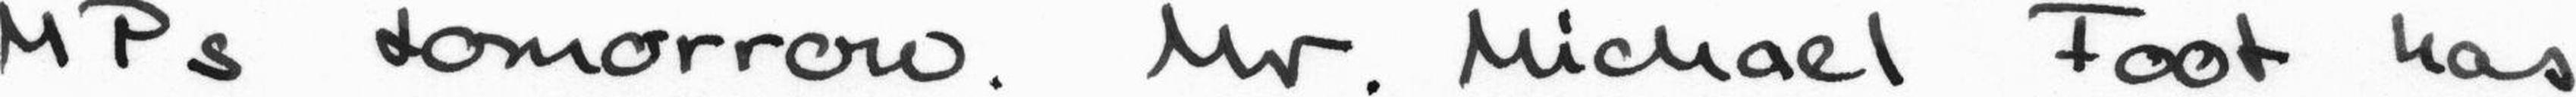

Sample 5:
Text: Griffiths, M P for Manchester Exchange .


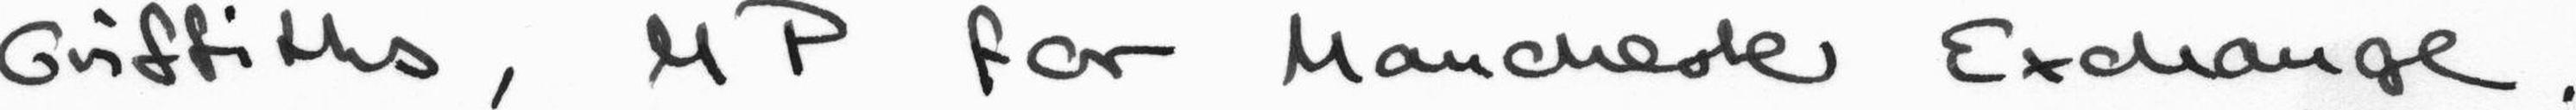

In [3]:
# Display the first 5 samples
for i in range(5):
    print(f"Sample {i+1}:")
    print(f"Text: {dataset_list[i]['text']}")
    display(dataset_list[i]['image'])


In [19]:
!pip install transformers datasets tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, get_scheduler
from torch.cuda.amp import GradScaler
from torch.amp import autocast  # Use this for mixed precision
from tqdm import tqdm
from PIL import Image


In [26]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

# Fix missing config attributes
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (i

In [27]:
def preprocess_function(examples):
    images = examples["image"]
    texts = examples["text"]

    rgb_images = []
    for img in images:
        if img.mode != "RGB":
            img = img.convert("RGB")
        rgb_images.append(img)

    pixel_values = processor(images=rgb_images, return_tensors="pt").pixel_values
    labels = processor.tokenizer(texts, padding="max_length", truncation=True, max_length=128).input_ids

    labels = [[(label if label != processor.tokenizer.pad_token_id else -100) for label in label_seq] for label_seq in [labels]][0]

    return {"pixel_values": pixel_values, "labels": torch.tensor(labels)}


In [28]:
class IAMLineDataset(Dataset):
    def __init__(self, hf_dataset):
        self.dataset = hf_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        example = self.dataset[idx]
        processed = preprocess_function({"image": [example["image"]], "text": [example["text"]]})
        return {
            "pixel_values": processed["pixel_values"].squeeze(0),
            "labels": processed["labels"].squeeze(0)
        }


In [29]:
# Assuming you already loaded your dataset into `dataset_list` (a list or Huggingface Dataset)

train_dataset = IAMLineDataset(dataset_list[:1000])  # Using first 1000 samples for quick start
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)


In [30]:
optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_loader) * 10  # 10 epochs

lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)
scaler = GradScaler()


<ipython-input-30-938b05bef3fd>:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [31]:
model.train()
num_epochs = 10

for epoch in range(num_epochs):
    loop = tqdm(train_loader, leave=True)
    running_loss = 0.0

    for batch in loop:
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()

        with autocast("cuda"):  # Mixed precision training
            outputs = model(pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        lr_scheduler.step()

        running_loss += loss.item()
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1} finished with average loss: {avg_loss:.4f}")


Epoch [1/10]: 100%|██████████| 250/250 [01:43<00:00,  2.42it/s, loss=0.185]


Epoch 1 finished with average loss: 0.7672


Epoch [2/10]: 100%|██████████| 250/250 [01:37<00:00,  2.56it/s, loss=0.255]


Epoch 2 finished with average loss: 0.2345


Epoch [3/10]: 100%|██████████| 250/250 [01:37<00:00,  2.56it/s, loss=0.223]


Epoch 3 finished with average loss: 0.2439


Epoch [4/10]: 100%|██████████| 250/250 [01:37<00:00,  2.57it/s, loss=0.0443]


Epoch 4 finished with average loss: 0.1021


Epoch [5/10]: 100%|██████████| 250/250 [01:37<00:00,  2.58it/s, loss=0.0369]


Epoch 5 finished with average loss: 0.0515


Epoch [6/10]: 100%|██████████| 250/250 [01:36<00:00,  2.58it/s, loss=0.11]


Epoch 6 finished with average loss: 0.0579


Epoch [7/10]: 100%|██████████| 250/250 [01:36<00:00,  2.58it/s, loss=0.0468]


Epoch 7 finished with average loss: 0.0350


Epoch [8/10]: 100%|██████████| 250/250 [01:37<00:00,  2.58it/s, loss=0.0163]


Epoch 8 finished with average loss: 0.0113


Epoch [9/10]: 100%|██████████| 250/250 [01:37<00:00,  2.56it/s, loss=0.00267]


Epoch 9 finished with average loss: 0.0058


Epoch [10/10]: 100%|██████████| 250/250 [01:37<00:00,  2.57it/s, loss=0.000814]

Epoch 10 finished with average loss: 0.0031


In [32]:
model.save_pretrained("fine_tuned_trocr")
processor.save_pretrained("fine_tuned_trocr")


[]

In [36]:
!pip install jiwer --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 64.4 MB/s eta 0:00:00


In [37]:
import evaluate

cer_metric = evaluate.load("cer")
wer_metric = evaluate.load("wer")


In [42]:
def preprocess_function_test(examples):
    images = [Image.open(path).convert("RGB") for path in examples["file"]]
    pixel_values = processor(images=images, return_tensors="pt").pixel_values
    labels = processor.tokenizer(examples["text"], padding="max_length", truncation=True, return_tensors="pt").input_ids
    return {"pixel_values": pixel_values, "labels": labels}


In [44]:
from datasets import load_dataset

dataset = load_dataset("Teklia/IAM-line")


train.parquet:   0%|          | 0.00/167M [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/24.7M [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/73.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6482 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/976 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2915 [00:00<?, ? examples/s]

In [47]:
def preprocess_function_test(examples):
    images = [image.convert("RGB") for image in examples["image"]]
    pixel_values = processor(images=images, return_tensors="pt").pixel_values
    labels = processor.tokenizer(examples["text"], padding="max_length", truncation=True, return_tensors="pt").input_ids
    return {"pixel_values": pixel_values, "labels": labels}


In [2]:
test_dataset = dataset["test"].map(preprocess_function_test, batched=True)
test_dataset.set_format(type="torch", columns=["pixel_values", "labels"])

from torch.utils.data import DataLoader
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


NameError: name 'dataset' is not defined

In [1]:
model.eval()
cer_scores = []
wer_scores = []

for batch in test_loader:
    pixel_values = batch["pixel_values"].to(device)
    labels = batch["labels"]

    with torch.no_grad():
        generated_ids = model.generate(pixel_values)
    preds = processor.batch_decode(generated_ids, skip_special_tokens=True)
    targets = processor.batch_decode(labels, skip_special_tokens=True)

    cer_scores.append(cer_metric.compute(predictions=preds, references=targets))
    wer_scores.append(wer_metric.compute(predictions=preds, references=targets))

print(f"Avg CER: {sum(cer_scores)/len(cer_scores):.4f}")
print(f"Avg WER: {sum(wer_scores)/len(wer_scores):.4f}")


NameError: name 'model' is not defined

In [1]:
!pip install datasets transformers accelerate evaluate jiwer --quiet


In [2]:
import torch
from transformers import VisionEncoderDecoderModel, TrOCRProcessor
from datasets import load_dataset
import evaluate
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model.to(device)

model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, eve

In [4]:
dataset = load_dataset("Teklia/IAM-line")


In [5]:
def preprocess_function_test(example):
    image = example["image"].convert("RGB")
    pixel_values = processor(image, return_tensors="pt").pixel_values.squeeze(0)

    labels = processor.tokenizer(example["text"], padding="max_length", max_length=128, truncation=True).input_ids
    labels = [label if label != processor.tokenizer.pad_token_id else -100 for label in labels]

    return {"pixel_values": pixel_values, "labels": torch.tensor(labels)}


In [6]:
test_dataset = dataset["test"].map(preprocess_function_test)
test_dataset.set_format(type="torch", columns=["pixel_values", "labels"])

test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


Map:   0%|          | 0/2915 [00:00<?, ? examples/s]

In [7]:
cer = evaluate.load("cer")
wer = evaluate.load("wer")


In [9]:
model.eval()
cer_scores = []
wer_scores = []

for batch in tqdm(test_loader):
    with torch.no_grad():
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"]

        generated_ids = model.generate(pixel_values)
        preds = processor.batch_decode(generated_ids, skip_special_tokens=True)

        clean_labels = labels.clone()
        clean_labels[clean_labels == -100] = processor.tokenizer.pad_token_id
        refs = processor.batch_decode(clean_labels, skip_special_tokens=True)

        cer_scores.append(cer.compute(predictions=preds, references=refs))
        wer_scores.append(wer.compute(predictions=preds, references=refs))

avg_cer = sum(cer_scores) / len(cer_scores)
avg_wer = sum(wer_scores) / len(wer_scores)

print(f"\nAverage CER: {avg_cer:.4f}")
print(f"Average WER: {avg_wer:.4f}")


100%|██████████| 729/729 [09:15<00:00,  1.31it/s]


Average CER: 0.0477
Average WER: 0.1155


In [12]:
model.save_pretrained("./trock_iam_model")
processor.save_pretrained("./trock_iam_processor")


[]

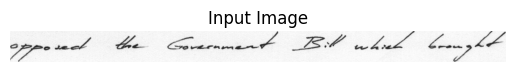

Predicted text: opposed the Government Bill which brought


In [19]:
from PIL import Image
import matplotlib.pyplot as plt

# Load and show image
image = Image.open("/content/test image.jpg").convert("RGB")
plt.imshow(image)
plt.axis('off')
plt.title("Input Image")
plt.show()

# Preprocess and predict
pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)
generated_ids = model.generate(pixel_values)
predicted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

print("Predicted text:", predicted_text)
